# Dogs vs Cats Classification using Convolutional Neural   Network

## Importing our dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import os 
from random import shuffle
import cv2

TEST_DIR = '/media/harsath/projects/tensorflow/My projects/dogs vs cats/test'
TRAIN_DIR = '/media/harsath/projects/tensorflow/My projects/dogs vs cats/train'
LEARNING_RATE = 1e-3
MODEL_NAME = "dogsvscats-{}-{}.model".format(LEARNING_RATE,"6conv-fire")
IMAGE_SIZE = 50

/home/harsath/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Labeling our dataset

In [2]:
def label_image(img):
    img_name = img.split(".")[-3]
    if img_name == "cat":
        return [1,0]
    elif img_name == "dog":
        return [0,1]

## Creating Training data loder function

In [3]:
def train_data_loder():
    training_data = []
    for img in tqdm(os.listdir(path=TRAIN_DIR)):
        img_lable = label_image(img)
        path_to_img = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path_to_img,cv2.IMREAD_GRAYSCALE),(IMAGE_SIZE,IMAGE_SIZE))
        training_data.append([np.array(img),np.array(img_lable)])
        
    shuffle(training_data)
    np.save("training_data_new.npy",training_data)
    return training_data

## Creating our test data(Loader function)

In [12]:
def testing_data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        img_labels = img.split(".")[0]
        path_to_img = os.path.join(TEST_DIR,img)
        img = cv2.resize(cv2.imread(path_to_img,cv2.IMREAD_GRAYSCALE),(IMAGE_SIZE,IMAGE_SIZE))
        test_data.append([np.array(img),np.array(img_labels)])
        
    shuffle(test_data)
    np.save("test_dataone.npy",test_data)
    return test_data

In [5]:
train_data_g = np.load('training_data_new.npy')

## Creating our tflearn Convolutional neural network model

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

In [7]:
import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMAGE_SIZE, IMAGE_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LEARNING_RATE, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
if os.path.exists("{}.meta".format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("Model Loaded")

INFO:tensorflow:Restoring parameters from /media/harsath/projects/tensorflow/My projects/dogs vs cats/dogsvscats-0.001-6conv-fire.model
Model Loaded


## Spliting our train and test data

In [9]:
train = train_data_g[:-500]
test = train_data_g[-500:]

In [10]:
#This is our Training data
X = np.array([i[0] for i in train]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)
Y = [i[1] for i in train]

#This is our Training data
test_x = np.array([i[0] for i in test]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)
test_y = [i[1] for i in test]


## Training our Network and saving the it with 82% accuracy

In [63]:
model.fit(X, Y, n_epoch=6, validation_set=(test_x,  test_y), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 2297  | total loss: 0.41589 | time: 59.995s
| Adam | epoch: 006 | loss: 0.41589 - acc: 0.8189 -- iter: 24448/24500
Training Step: 2298  | total loss: 0.41209 | time: 61.160s
| Adam | epoch: 006 | loss: 0.41209 - acc: 0.8183 | val_loss: 0.45129 - val_acc: 0.7980 -- iter: 24500/24500
--


In [11]:
model.save(MODEL_NAME)

INFO:tensorflow:/media/harsath/projects/tensorflow/My projects/dogs vs cats/dogsvscats-0.001-6conv-fire.model is not in all_model_checkpoint_paths. Manually adding it.


In [15]:
test_data = np.load("test_dataone.npy")

## Ploting 12 random data from test set

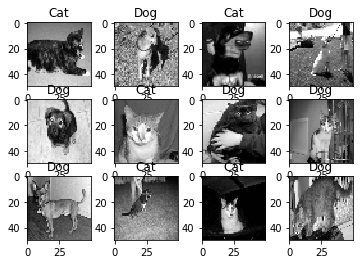

In [45]:
import matplotlib.pyplot as plt

figs = plt.figure()
for num,data in enumerate(test_data[:12]):
    test_img = data[0]
    test_lable = data[1]
    test_img_feed = test_img.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
    t = figs.add_subplot(3,4,num+1)
    ores = test_img
    model_pred = model.predict([test_img_feed])[0]
    if np.argmax(model_pred) == 1:
        pred_val = "Dog"
    else:
        pred_val = "Cat"
        
    t.imshow(ores,cmap="gray")
    plt.title(pred_val)
    

## Saving the prediction file for Dogness

In [44]:
with open("final_results(dogs).csv",mode="w") as f:
    f.write("id,pred \n")
    
with open("final_results.csv(dogs)",mode="a") as r:
    for data in tqdm(test_data):
        img_class = data[1]
        img = data[0]
        imgs = img.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        model_out = model.predict([imgs])[0]
        r.write("{},{} \n".format(img_class,model_out[1]))
        
    

100%|██████████| 12500/12500 [00:37<00:00, 333.21it/s]
